In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx
import pystan_utils

plt.style.use('ggplot')
%matplotlib inline

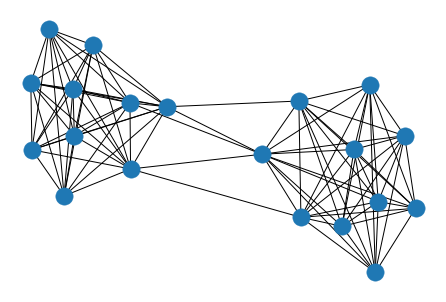

In [2]:
num_each = 20
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 5
between = 10
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2,size=(num_each//2, num_each//2))
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T


mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)

mat[0,-1] = mat[-1,0] = np.random.poisson(between)
mat[0,-2] = mat[-2,0] = np.random.poisson(between)
mat[1,-2] = mat[-2,1] = np.random.poisson(between)
mat[2,-2] = mat[-2,2] = np.random.poisson(between)
mat[2,-3] = mat[-3,2] = np.random.poisson(between)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

In [3]:
model_code= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;                           // priors on lambda
        real c;
        real d;
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            for(j in 1:K)
                if(j==k){
                    lambda[k,j] ~ gamma(c,d);
                }else{
                    lambda[k,j] ~ gamma(a,b);
                }
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
            }
        }

}
"""

In [4]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3be6d669e276c97fe04930ee9ae1728c NOW.


In [5]:
n = num_each
k = 2
#alpha = sparse_alpha(5, k)
alpha = np.ones(2)
data = {'X' : mat, 'N' : n, 'K' : k, 'alpha' : alpha, 'a' : 7.5, 'b' : 1, 'c':5, 'd':3}
fit = sm.vb(data=data, iter=10000)

In [6]:
pies = pystan_utils.vb_extract_variable(fit, "pi", var_type="matrix", dims=[k,n])

In [7]:
extract = pystan_utils.vb_extract(fit)

In [8]:
groups = np.argmax(pies,axis=0)

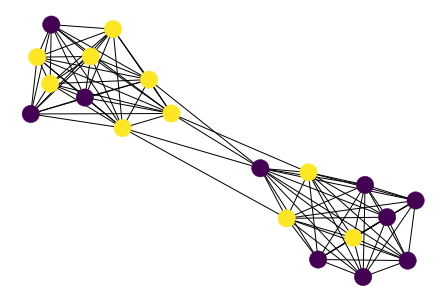

In [9]:
#pi = pies
#groups = np.argmax(pi[-1],axis = 1)
nx.draw(G,node_color = groups)

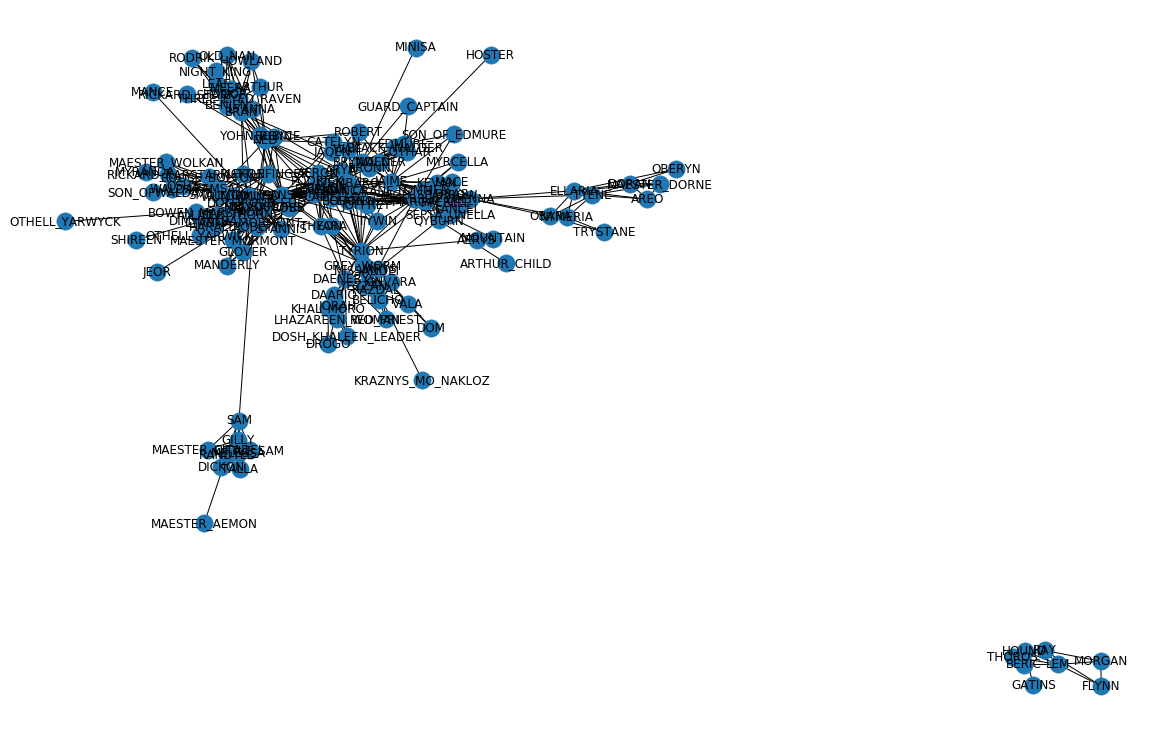

In [10]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s6-nodes.csv')
edges = pd.read_csv('../data/got-s6-edges.csv')

# Initialize the graph based on the data from Game of Thrones Season 6
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Conver to numpy to use with STAN
graph = nx.to_numpy_matrix(G, dtype=int)
plt.figure(figsize=(16,10))
nx.draw(G, color='r', label = nodes["Label"], with_labels=True)

In [11]:
n = graph.shape[0]
k = 6
iterations = 10000
alpha = np.ones(k)
#alpha = sparse_alpha(5, k)
data = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : alpha, 
        'a' : 0.1, 'b' :  0.1, 'c': 0.5,'d': 0.5}

In [12]:
fit = sm.vb(data = data, iter = iterations, output_samples = iterations)

In [ ]:
fit = sm.sampling(data=data, iter=iterations, chains=1)

In [19]:
fitvar = pystan_utils.vb_extract(fit)

In [ ]:
colnames = pi[1,1]

In [20]:
from sklearn.feature_extraction import DictVectorizer
dictvectorizer = DictVectorizer(sparse=False)
features = dictvectorizer.fit_transform(fitvar[0])


ValueError: data, indices, and indptr should be 1-D

In [13]:
pi_hat = pystan_utils.vb_extract_variable(fit, "pi", var_type="matrix", dims=[k,n])

In [ ]:
pi = fit.extract()["pi"]

In [ ]:
groups = np.argmax(pi,axis = 1)

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)

In [ ]:
def sparse_alpha(A, K):
    alpha = np.zeros(3*K)
    alpha[:K] = A
    
    for idx,i in enumerate(range(K,3*K)):
        alpha[i] = A*np.exp(-0.25*idx)
    
    return alpha


In [ ]:
groups = fit.extract()["pi"]

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [ ]:
scores = []
for i in range(1, iterations//2):
    cluster1 = np.argmax(groups[i-4], axis = 1)
    cluster2 = np.argmax(groups[i-3], axis = 1)
    scores.append(adjusted_mutual_info_score(cluster1, cluster2))

In [ ]:
plt.plot(scores)

In [14]:
groups = np.argmax(pi_hat,axis = 0)

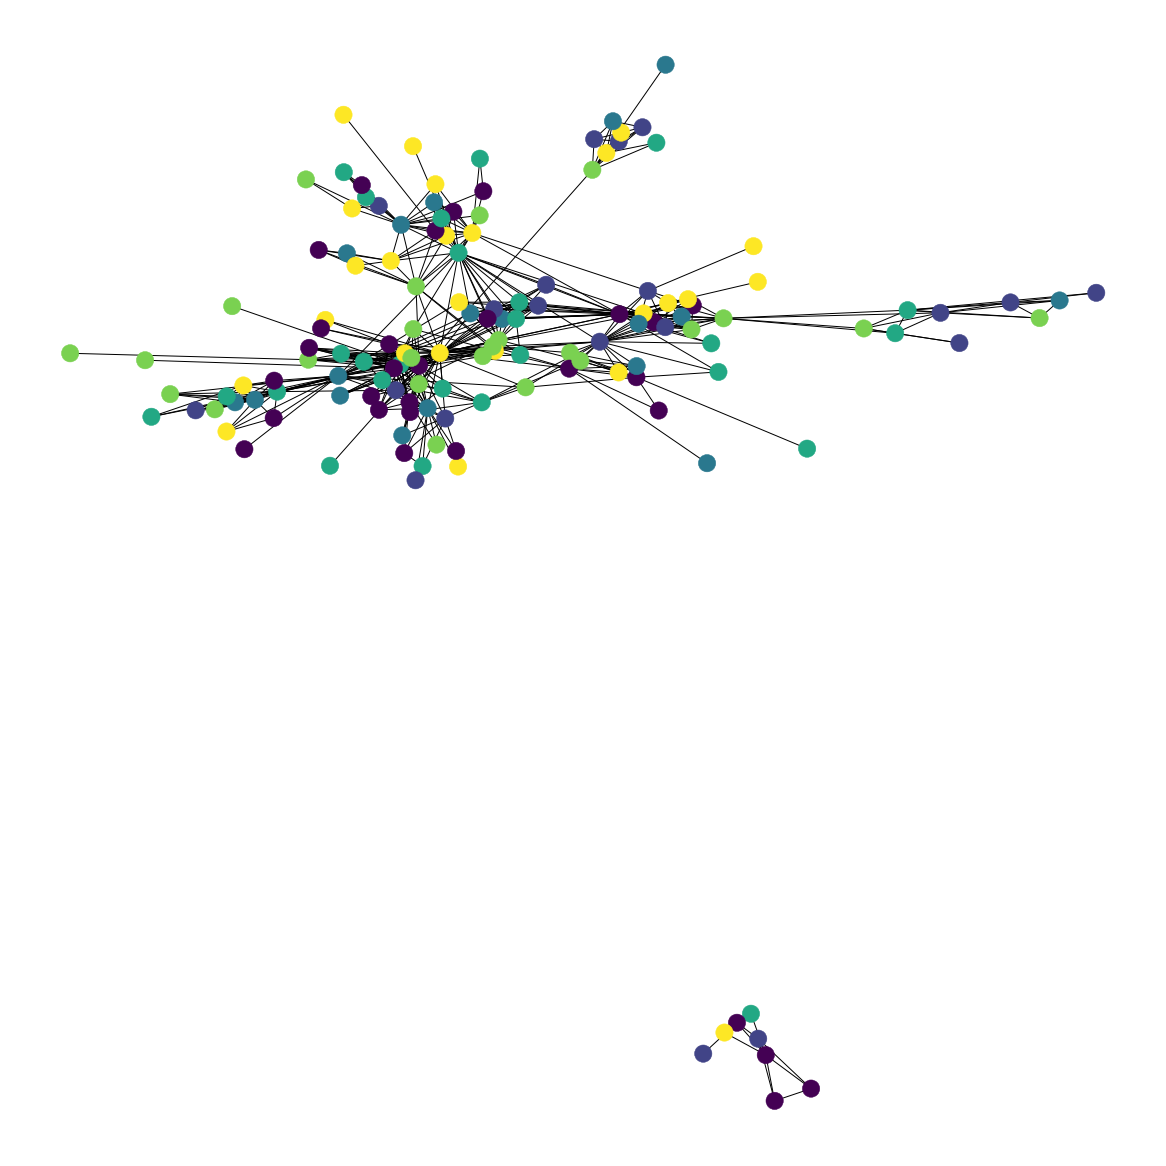

In [15]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)